# Sklearn Workshop 3: Car Price Prediction (Regression)


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: ETL

In [35]:
df = pd.read_csv("data/car.csv")

In [36]:
# df.describe()  #no missing values, seems like....
# df.dtypes
# df['selling_price'].value_counts()  #no need to check imbalanced because this is a regression problem
df.head()

#?Note: We don't need the year.....because year can be linearly correlated with price but with no meaning due to inflation anyway
#?      Some missing values in seats?
#?      Wow, so many object.....we need encoding :-(
#?      We don't need name too....because name won't be related to price.....
#?      Oh...we have to fix the mileage and remove kmpl....
#?      We have to remove CC in engine
#?      We have to remove bhp
#?      Based on domain expert, we shall drop torque (ok?)

#selling_price:  our target

#continuous: km_driven, mileage, engine, max_power, torque
#discrete:   seats, fuel, seller_type, transmission, owner, 

#seats can be both continuous or discrete...up to you

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


### 1.1  Fix the columns (extract the meaning from the text)

In [37]:
df['owner'].value_counts()

First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64

In [38]:
df['owner'] = df['owner'].map({'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3, 'Fourth & Above Owner': 4, 'Test Drive Car': 5})

In [39]:
df['owner'].value_counts()

1    5289
2    2105
3     555
4     174
5       5
Name: owner, dtype: int64

In [40]:
df.fuel.value_counts()

Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: fuel, dtype: int64

In [41]:
#let's delete all rows with CNG and LPG
#because CNG and LPG use a different mileage system, i.e., km/kg which is different from kmpl for Diesel and Petrol
condCNG = df.fuel == 'CNG'
condLPG = df.fuel == 'LPG'
condCNG_index = np.where(condCNG | condLPG)  #retrieve the index
df.drop(condCNG_index[0], axis=0, inplace=True)

In [42]:
df.fuel.value_counts()

Diesel    4402
Petrol    3631
Name: fuel, dtype: int64

In [43]:
df.mileage = df.mileage.str.split(" ").str[0]

In [44]:
df.engine = df.engine.str.split(" ").str[0]

In [45]:
df.max_power = df.max_power.str.split(" ").str[0]

In [46]:
df = df.rename(columns={'name': 'brand'})

In [47]:
df.brand = df.brand.str.split(" ").str[0]  #a scientist choice, no right no wrong....

In [48]:
df = df.drop(columns=['torque'])

In [49]:
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.4,1248,74,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498,103.52,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.7,1497,78,5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.0,1396,90,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.1,1298,88.2,5.0


In [50]:
df.mileage = df.mileage.astype('float')
df.engine  =  df.engine.astype('float')
df.max_power = df.max_power.astype('float')

In [51]:
df.dtypes

brand             object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner              int64
mileage          float64
engine           float64
max_power        float64
seats            float64
dtype: object

### Step 2: EDA

In [52]:
df.head(1)

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.4,1248.0,74.0,5.0


In [53]:
dis_col = ['year', 'brand', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']
con_col = ['km_driven', 'mileage', 'engine', 'max_power']

In [54]:
#plot the categorical columns
# for col in dis_col:
#     sns.barplot(x = df[col], y = df['selling_price'])  #since our y is continuous, we put x as our categories, and use bar plot
#     plt.xticks(rotation=90)
#     plt.show()

#? We learn that:  brand, fuel, seller_type, transmission, owner*, seats
#? We have to check the owner, and maybe fix the outliers...........
#? So we deleted the test drive, so now we can use owner as another nice feature, because 1 owner is most expensive....

In [55]:
#we found out there are only five test drive cars...and they are "ridicously expensive"
#also we are not interested in predicting price of test_drive cars
#so let's delete them
cond = df.owner != 5
df = df[cond]

#another way
# cond = df.owner == 5
# index = np.where(cond)
# df = df.drop(index)

In [56]:
df.owner.value_counts()

1    5238
2    2073
3     547
4     170
Name: owner, dtype: int64

In [57]:
# for col in con_col:
#     sns.scatterplot(x=df[col], y=df['selling_price'])  #use scatter plot because both are continuous
#     plt.show()
    
#? We learn that:  year, km_driven, engine, max_power

In [58]:
# plt.figure(figsize=(20, 10))
# sns.heatmap(df.corr(), annot=True)

### Conclusion:

We will use:   **year, km_driven, engine, max_power, brand, fuel, seller_type, transmission, owner, seats**

### Step 3: Encoding

In [59]:
#Encoding can be done before splitting anyway, because they won't affect data leakage
df = pd.get_dummies(df, columns=['brand'], drop_first=True)
#because you make some internal correlation....that is 30 columns are correlated to that last column

In [60]:
df['fuel'] = df['fuel'].map({'Petrol': 0, 'Diesel': 1})

In [61]:
df = pd.get_dummies(df, columns=['seller_type'], drop_first=True)

In [62]:
df['transmission'] = df['transmission'].map({'Manual': 0, 'Automatic': 1})

In [63]:
df.head()

,year,selling_price,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats,...,brand_Opel,brand_Peugeot,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo,seller_type_Individual,seller_type_Trustmark Dealer
0,2014,450000,145500,1,0,1,23.40,1248.0,74.00,5.0,...,0,0,0,0,0,0,0,0,1,0
1,2014,370000,120000,1,0,2,21.14,1498.0,103.52,5.0,...,0,0,0,1,0,0,0,0,1,0
2,2006,158000,140000,0,0,3,17.70,1497.0,78.00,5.0,...,0,0,0,0,0,0,0,0,1,0
3,2010,225000,127000,1,0,1,23.00,1396.0,90.00,5.0,...,0,0,0,0,0,0,0,0,1,0
4,2007,130000,120000,0,0,1,16.10,1298.0,88.20,5.0,...,0,0,0,0,0,0,0,0,1,0


In [64]:
df.columns

Index(['year', 'selling_price', 'km_driven', 'fuel', 'transmission', 'owner',
       'mileage', 'engine', 'max_power', 'seats', 'brand_Ashok', 'brand_Audi',
       'brand_BMW', 'brand_Chevrolet', 'brand_Daewoo', 'brand_Datsun',
       'brand_Fiat', 'brand_Force', 'brand_Ford', 'brand_Honda',
       'brand_Hyundai', 'brand_Isuzu', 'brand_Jaguar', 'brand_Jeep',
       'brand_Kia', 'brand_Land', 'brand_Lexus', 'brand_MG', 'brand_Mahindra',
       'brand_Maruti', 'brand_Mercedes-Benz', 'brand_Mitsubishi',
       'brand_Nissan', 'brand_Opel', 'brand_Peugeot', 'brand_Renault',
       'brand_Skoda', 'brand_Tata', 'brand_Toyota', 'brand_Volkswagen',
       'brand_Volvo', 'seller_type_Individual',
       'seller_type_Trustmark Dealer'],
      dtype='object')

We will use:   **year, km_driven, engine, max_power, brand, fuel, seller_type, transmission, owner, seats**

### Step 4: Splitting

In [65]:
X = df[['year', 'km_driven', 'engine', 'max_power', 'fuel', 'seller_type_Individual', 'seller_type_Trustmark Dealer',
        'transmission', 'owner', 'seats']]
y = df['selling_price']

assert X.ndim == 2
assert y.ndim == 1

X.shape, y.shape

((8028, 10), (8028,))

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=999)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5619, 10), (2409, 10), (5619,), (2409,))

### Step 5: Preprocessing

##### 5.1 Filling missing values

In [67]:
#double check that no missing values....
# X_train.isna().sum()     #fix engine, max_power, seats
# X_test.isna().sum()      #fix engine, max_power, seats
# y_train.isna().sum()   #no need to fix y_train
# y_test.isna().sum()    #no need to fix y_test

In [68]:
#since engine, max_power are continuous, we check whether to replace with mean() or median()
#for seats, we can replace with ratio or majority.
#note that we replace the testing set USING training statistics.

# sns.displot(X_train.max_power)
# X_train.max_power.mean(), X_train.max_power.median()  

#! median for engine, max_power

In [69]:
X_train['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_train['engine'].fillna(X_train['engine'].median(), inplace=True)

assert X_train['max_power'].isna().sum() == 0 
assert X_train['engine'].isna().sum() == 0 

<ipython-input-69-5cb4d16d16c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['max_power'].fillna(X_train['max_power'].median(), inplace=True)
<ipython-input-69-5cb4d16d16c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['engine'].fillna(X_train['engine'].median(), inplace=True)


In [70]:
X_test['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_test['engine'].fillna(X_train['engine'].median(), inplace=True)

assert X_test['max_power'].isna().sum() == 0 
assert X_test['engine'].isna().sum() == 0 

<ipython-input-70-b585b3d8f7e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['max_power'].fillna(X_train['max_power'].median(), inplace=True)
<ipython-input-70-b585b3d8f7e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['engine'].fillna(X_train['engine'].median(), inplace=True)


In [71]:
ratio = X_train.seats.value_counts(normalize=True)

#1. find how many are missing
cond          = X_train.seats.isna()
missing       = X_train.seats.isna().sum()
missing_index = X_train[cond].index

#np.where(cond) gives you the implicit index

#2. define the series
series = pd.Series(np.random.choice(list(ratio.index), p=list(ratio), 
                            size=missing), index = missing_index)

#3. fill the number with this series
X_train.seats.fillna(series, inplace=True)

# print(X_train.seats.value_counts(normalize=True))

X_train.seats.isna().sum()

<ipython-input-71-ec0da226f534>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.seats.fillna(series, inplace=True)


0

In [72]:
#1. find how many are missing
cond          = X_test.seats.isna()
missing       = X_test.seats.isna().sum()
missing_index = X_test[cond].index

#np.where(cond) gives you the implicit index

#2. define the series
series = pd.Series(np.random.choice(list(ratio.index), p=list(ratio), 
                            size=missing), index = missing_index)

#3. fill the number with this series
X_test.seats.fillna(series, inplace=True)

# print(X_test.seats.value_counts(normalize=True))

X_test.seats.isna().sum()

<ipython-input-72-db4959fac741>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.seats.fillna(series, inplace=True)


0

In [73]:
X_train.isna().sum()
X_test.isna().sum()

year                            0
km_driven                       0
engine                          0
max_power                       0
fuel                            0
seller_type_Individual          0
seller_type_Trustmark Dealer    0
transmission                    0
owner                           0
seats                           0
dtype: int64

##### 5.2 Standardization

In [74]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
col_to_scale = ['km_driven', 'engine', 'max_power']

X_train.loc[:, col_to_scale] = sc.fit_transform(X_train.loc[:, col_to_scale]) #we scale all features, because all our features are continuous
X_test.loc[:,  col_to_scale] = sc.transform(X_test.loc[:, col_to_scale])

#we did not transform y_test or y_train

#after standardize, the mean should be zero; the std should be 1
for feature in col_to_scale:
    assert np.isclose(X_train.loc[:, feature].mean(), 0, atol = 0.0001)  #cannot == 0 because is near 0 not 0
    assert np.isclose(X_train.loc[:, feature].std(),  1, atol = 0.0001)
    #we don't need to assert for X_test, because we use training statistics to transform X_test, so it won't be mean0 std1

<ipython-input-74-889038b689bd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, col_to_scale] = sc.fit_transform(X_train.loc[:, col_to_scale]) #we scale all features, because all our features are continuous
<ipython-input-74-889038b689bd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.loc[:,  col_to_scale] = sc.transform(X_test.loc[:, col_to_scale])


### Step 6: Modeling

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#models
lr, sv, rf, gb = LinearRegression(), SVR(), RandomForestRegressor(), GradientBoostingRegressor()

models = [lr, sv, rf, gb]
names  = ["lr", "sv", "rf", "gb"]

for idx, model in enumerate(models):
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, scoring='neg_mean_squared_error') #no need cv and scoring because their default is ok in our case
    print(f"{names[idx]} - Mean: {score.mean()}; Std: {score.std()}")

lr - Mean: -193559720468.82324; Std: 18765037502.368107
sv - Mean: -621958999474.7649; Std: 60017873080.14043
rf - Mean: -28111025445.733887; Std: 9859781024.66401
gb - Mean: -32481864090.85509; Std: 11129641776.317097


In [76]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth'   : [5, 10, None],
    'max_features': ['auto', 'log2'],
    'n_estimators': [5, 6, 99, 8, 9, ]
}

#3. define the base model
rf = RandomForestRegressor()

#4. create the gridsearch object
grid = GridSearchCV(estimator=rf,param_grid=param_grid,
                    n_jobs=-1,return_train_score=True,refit=True,
                    scoring="neg_mean_squared_error"
)

#5. run grid search
grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [5, 6, 99, 8, 9]},
             return_train_score=True, scoring='neg_mean_squared_error')

### Step 7: Testing

In [77]:
pred_y = grid.predict(X_test)

In [78]:
from sklearn.metrics import mean_squared_error, r2_score #you can try absolute, root

print("MSE: ", mean_squared_error(y_test, pred_y))
print("R2: ", r2_score(y_test, pred_y))

MSE:  21168344235.898155
R2:  0.9723325773260276


### Step 8: Feature Importance

In [79]:
grid.best_estimator_.feature_importances_ 

array([1.75665479e-01, 4.23679298e-02, 2.67510496e-02, 7.37061298e-01,
       3.55967978e-03, 4.47127740e-03, 2.74303328e-04, 3.05532254e-03,
       2.14809765e-03, 4.64556320e-03])

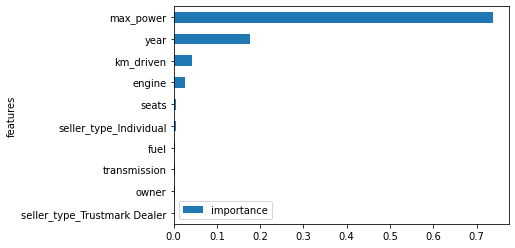

In [80]:
feature_importance = pd.DataFrame(list(X.columns), 
                                  columns=['features'])

feature_importance['importance'] = grid.best_estimator_.feature_importances_ 
feature_importance = feature_importance.sort_values(by = ['importance'], ascending=True)

feature_importance.plot.barh(x='features')
plt.show()

### Step 8: Saving the models

In [81]:
#please help me save the model here
import pickle

# save the model
filename = 'car_price.pkl' # pkl does not matter, you can do .everything
pickle.dump(grid, open(filename,'wb'))

# Load the model
loaded_grid=pickle.load(open(filename,'rb'))

# try predict X_test
loaded_grid.predict(X_test)

# if you have new data, then you fit again....but using loaded_grid
# which is a process of training more.....once you have more data....

# or another way is
# put all the dataset together, and train like it is new
    #this is possible ONLY if your dataset is not that big......


array([196414.11111111, 562737.36363636, 370262.61616162, ...,
       188999.98989899, 223749.49494949, 204848.26262626])